# Capstone - Classifying plastic resin codes for recycling

Under the [Sustainable Singapore Blueprint](https://www.straitstimes.com/multimedia/graphics/2022/04/recycle-me-not/index.html), Singapore wants to improve the domestic recycling rate to 30 per cent by 2030. Indeed, there has been many educational posters and campaigns to promote recycling such as the [Bloobox vended islandwide](https://www.nea.gov.sg/media/news/news/index/a-free-bloobox-for-every-household-to-encourage-recycling-at-home) from March to April, earlier this year.

According ot the [nea recycling statistics](https://www.nea.gov.sg/our-services/waste-management/waste-statistics-and-overall-recycling) the total amount of waste generated increased from 6.94 to 7.39 million tones in 2022. Of this 7.39 millions tones, the plastics waste stream accounted for 1.001 million tonnes. Only 57,000 tonnes were recycled, a mere 6%. In fact, the [domestic recycling rate in Singapore in 2022 was the lowest recycling rate in more than a decade](https://www.straitstimes.com/singapore/domestic-recycling-rate-in-singapore-lowest-in-over-a-decade), dropping 12 percent form the previous year. While the breakdown is not specified for domestic, it can be inferred that plastic recycling rates is around tha forementioned 6%. This is despite Singapore's [National Recycling Programme](https://www.nea.gov.sg/our-services/waste-management/3r-programmes-and-resources/national-recycling-programme) that was launched back in 2001 where the blue reycling bins and recycling collection services were made available to the public in HDB estates as well as private properties (landed and apartment/condomimums alike).


Blueprints, campaigns and programmes aside, it is equally important to delve into the materials itselves when recycling is mentioned. Plastic Identification Codes (or more accurately, Resin identification code) are commonly found marked on the plastic materials to facilitate the identification of the plastic type for recycling. Example below.
<center><img src="assets/plastic-resin-codes.jpg" width="512" height="300"> </center>

The purpose for labelling the different types of plastic is due to the different properties of each plastic resin at the molecular level. A clear difference woudld be the different temperatures that the resins melt at, in other words not all plastics are the same. This is of significance during the recyling process since where the purity of the various plastic resins being recycled would impact the final purity of the regenerated plastic raw material for use/sale. 

More importantly, Singapore acceded to the [Basel Convention](https://www.nea.gov.sg/corporate-functions/resources/legislation-international-law/multilateral-environmental-agreements/chemical-safety/basel-convention) back in 1996 which binds us to the threshold limit of < 0.5% contamination of single stream plastic waste. In other words, in order for materials recovery facility to export the materials to overseas facilities for further processing, it has to meet this criteria. This is a huge challenge on the materials recovery facility tasked to do as mentioned in a recent [CNA ariticle](https://www.channelnewsasia.com/cna-insider/plastic-recycling-rate-singapore-exports-bottled-water-safe-3723811) where the main issue at hand is contamination, manually identifying correctly, the resin type of the 'recycled' plastic as well as the economics of recycling such materials.

On top of this or in part due to the above reasons, it is important point to note that in singapore [not all plastics are recylable.](https://plasticlite.sg/) Only Resin identification code 1 (PET), 2 (HDPE), 4 (LDPE) and 5 (PP) are reyclable. The rest of the codes 3 (PVC), 6 (PS), and 7 (Others) are not recycled.

# Library imports

In [2]:
#Importing libraries and modules
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import pickle
import glob
#!pip install tensorflow
import tensorflow as tf

# For reproducibility
np.random.seed(42)

# Keras imports for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for imports
from tensorflow.keras import utils 
import cv2
from PIL import Image

# Keras imports for building NNs layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
device_name = tensorflow.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found


# Modeling

Due to the low quantity of images, training from scratch would not be feasible due to generasability concerns, Hence any models developed would have to use transfer learning in the from of existing network architectures to develop the desired use case.

Three pretrained models are selected to be used for modelling exploration MobileNet, EfficientNet and ResNet.

1. MobileNetV2 will be first explored since the targeted platforms are likely of mobiles or those with lighter computing power. MobileNetV3 will be explored as well since in the [MobilenetV3 paper](https://arxiv.org/pdf/1905.02244.pdf) the next version MobileNetV3-Large and MobileNetV3-Small has some improvements in accuracy and has lower latency so some improvements gains could be had.

2. EfficientNetV2M will be explored since it is utilises [Neural Architecture Search and model scaling](https://wisdomml.in/efficientnet-and-its-performance-comparison-with-other-transfer-learning-networks/#What_is_EfficientNet) to optimise the network and hence could show greater promise in improving the scores. While this comes at the expense of computational speed. and deployment size, a model with better scores would be more functional and hence prioritised.

3. ResNet will be explored as last in the hopes that the earlier models would have already higher scores and the ResNet models would be the architecture to see if a deeper learning network that seeks to minimise residuals for errors can lead to even more gains in the model scores to see what can be achieved.


In [3]:
#setting folder
train_bin_folder = 'data/train_binary/'
val_bin_folder = 'data/val_binary/'

## Metrics function
Accuracy works best if false positives and false negatives have similar cost which in this can be argued to be the case since false positives would lead to wasting of effort to recycle and contaminate the recycling streams and false negatives would lead to a wasted opportunity and the actual material itself
>
However, there is an underlying unevenness in class distribution as well as the fact that the binary classes is imbalanced as well. Thus, F1 Score is used as a balance between the Positive Prediction rate and the True positive rate which accounts the true positives amongst the false negatives and false positives respectively.


In [4]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import Metric
from sklearn.metrics import f1_score

In [73]:
class F1Score(Metric):
    def __init__(self, threshold=0.5, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = tf.keras.metrics.Precision(threshold)
        self.recall = tf.keras.metrics.Recall(threshold)
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred >= self.threshold, tf.float32)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [86]:
# For plotting 

def plot_curve(model_history):
    
    # Get values from history
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    train_f1 = model_history.history['f1_score']
    val_f1 = model_history.history['val_f1_score']
    
    # Plot loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, color='tab:blue', alpha = 0.5, label='Training loss') # plot training loss of original overfit model
    plt.plot(val_loss, color='orange', label='Validation loss') # plot val loss of original overfit model
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Plot of loss over epochs')
    plt.legend();
    
    # Plot F1 curve 
    plt.figure(figsize=(10, 6))
    plt.plot(train_f1, color='tab:blue', alpha = 0.5, label = 'Training F1 score') # plot training f1 of original overfit model
    plt.plot(val_f1, color='orange', label = 'Testing F1 score') # plot testing f1 of original overfit model
    plt.xlabel('Epochs')
    plt.ylabel('F1 score')
    plt.title('Plot of F1 score over epochs')
    plt.legend();

## MobileNetV2 transfer model
1. Direct application of pretrain model with sigmoid output layer, early stopping enabled.
2. Pretrain model with l2 regularization layer, sigmoid output layer, early stopping enabled.
3. Pretrain model with dropout layer, sigmoid output layer, early stopping enabled.

### Reimport augmented data

> Due to the requirements of the pretrain models, the images will be loaded as 224X224 even though the original data size is 200X200.

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess_input

In [7]:
# Load the Train and Validation data
mobnetv2_train_bin_data = ImageDataGenerator(preprocessing_function=mobilenet_preprocess_input).flow_from_directory(train_bin_folder, 
                                                                     target_size= (224,224), 
                                                                     batch_size= 32,
                                                                     class_mode= 'binary',
                                                                     seed = 42,
                                                                     shuffle=True
                                                                    )

mobnetv2_val_bin_data = ImageDataGenerator(preprocessing_function=mobilenet_preprocess_input).flow_from_directory(val_bin_folder, 
                                                                   target_size=(224,224), 
                                                                   class_mode='binary',
                                                                   seed = 42,
                                                                   shuffle=True
                                                                  )

Found 3119 images belonging to 2 classes.
Found 799 images belonging to 2 classes.


In [8]:
# Check the classes that ImageDataGenerator was able to find using .class_indices
class_mappings = mobnetv2_train_bin_data.class_indices 
print(class_mappings) 

{'0_non': 0, '1_recyclable': 1}


In [9]:
# Import the MobileNetV2 pre-trained transfer learning model
mob_netv2 = MobileNetV2(input_shape= (224, 224, 3) , include_top=False, pooling='avg')

# Freeze the model to prevent changes to the pre-trained model parameters during dense layer gradient descent
mob_netv2.trainable = False

### MobileNetV2 base model

In [10]:
# Create base model architecture & instantiate empty sequential model
base_mob_netv2 = Sequential() 

# Add pre-trained model to use Transfer Learnin (get all the weights from pre_trained_mode)
base_mob_netv2.add(mob_netv2) 

# Output layer
base_mob_netv2.add(Dense(1, activation= 'sigmoid')) #sigmoid for binary output

# Check model architecture compilation summary
base_mob_netv2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
#set callbacks

# Instantiating earlystopping
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.02, 
                           patience = 5, 
                           mode = 'auto'
                          )
# Instantiating checkpoint
checkpoint_callback = ModelCheckpoint(filepath = "./weights/base_mob_netv2_epoch/base_mob_netv2_epoch_{epoch:02d}_{f1_score:.2f}_{val_f1_score:.2f}.h5",
                                      save_weights_only = False,
                                      save_best_only = False,
                                      save_freq = 'epoch',
                                      verbose = 1
                                      )

In [12]:
epochs = 20

# Compile the model with adam optimizer and specify loss type.
opt = Adam(learning_rate=0.001) 
base_mob_netv2.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score()])

# Fit train model with early stopping -> higher epochs
history_base_mob_netv2 = base_mob_netv2.fit(x = mobnetv2_train_bin_data,
                             validation_data = mobnetv2_val_bin_data,
                             epochs = epochs,
                             batch_size = 32,
                             callbacks = [early_stop, checkpoint_callback]
                             )

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 0.5431 - f1_score: 0.7722
Epoch 1: saving model to ./weights/base_mob_netv2_epoch\base_mob_netv2_epoch_01_0.77_0.77.h5
98/98 [==============================] - 64s 626ms/step - loss: 0.5431 - f1_score: 0.7722 - val_loss: 0.5585 - val_f1_score: 0.7719
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.3861 - f1_score: 0.8693
Epoch 2: saving model to ./weights/base_mob_netv2_epoch\base_mob_netv2_epoch_02_0.87_0.80.h5
98/98 [==============================] - 67s 687ms/step - loss: 0.3861 - f1_score: 0.8693 - val_loss: 0.5354 - val_f1_score: 0.7956
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.3205 - f1_score: 0.9030
Epoch 3: saving model to ./weights/base_mob_netv2_epoch\base_mob_netv2_epoch_03_0.90_0.79.h5
98/98 [==============================] - 61s 627ms/step - loss: 0.3205 - f1_score: 0.9030 - val_loss: 0.5122 - val_f1_score: 0.7908
Epoch 4/20
98/98 [=========================

In [13]:
# pdf the history for quick comparison.
pd.DataFrame(history_base_mob_netv2.history, index = pd.RangeIndex(1,len(history_base_mob_netv2.history['loss'])+1))

,loss,f1_score,val_loss,val_f1_score
1,0.543107,0.772246,0.558526,0.771894
2,0.386096,0.869329,0.535413,0.795591
3,0.320493,0.903014,0.512205,0.790843
4,0.277331,0.919603,0.521997,0.806293
5,0.244373,0.934957,0.521358,0.814300
6,0.222710,0.940819,0.505636,0.811189
7,0.204643,0.949556,0.528818,0.824219
8,0.188144,0.955870,0.502879,0.811741


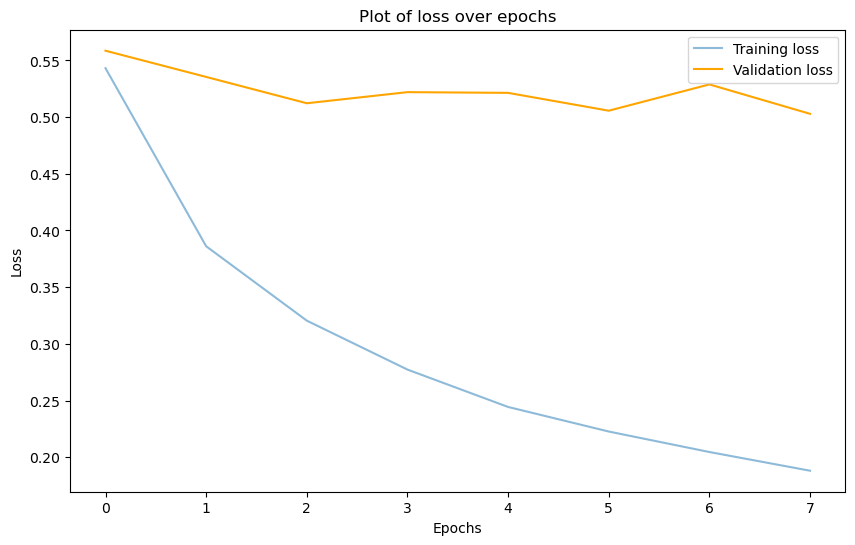

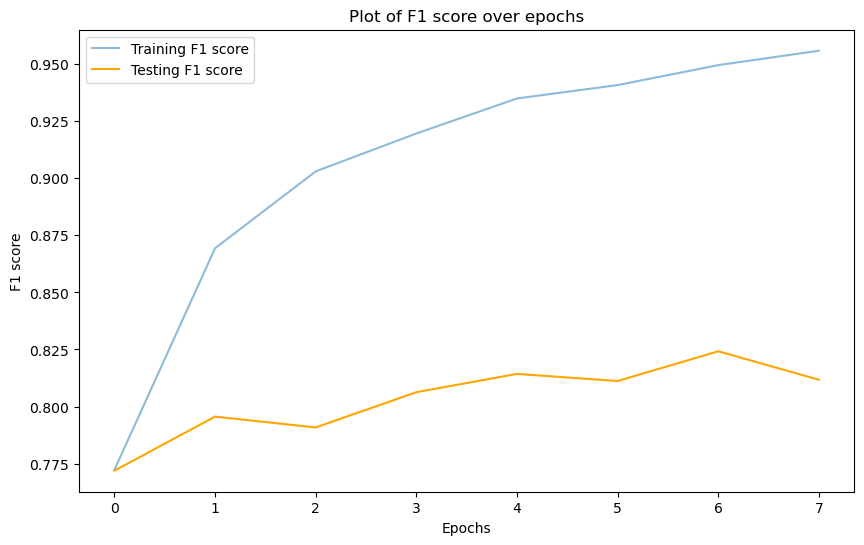

In [98]:
plot_curve(history_base_mob_netv2)

In [14]:
pickle.dump(history_base_mob_netv2, open('./weights/base_mob_netv2_epoch/history_base_mob_netv2.pkl', 'wb'))

> While the first epoch has somewhat decent scores, it is only the first epoch which makes the scores somewhat dubious. Expectedly overfitting is an issue and becomes very apparent in the second epochs onwards and is severe. Further explorations required to reduce overfit as well as improve f1 score.

### MobileNetV2 with l2 regularization

In [15]:
# Create base model architecture & instantiate empty sequential model
l2_mob_netv2 = Sequential() 

# Add pre-trained model to use Transfer Learnin (get all the weights from pre_trained_mode)
l2_mob_netv2.add(mob_netv2) 

# regularization layer
l2_mob_netv2.add(Dense(60, input_dim=1280, activation='relu', kernel_regularizer=l2(0.01)))

# Output layer
l2_mob_netv2.add(Dense(1, activation= 'sigmoid')) #sigmoid for binary output

# Check model architecture compilation summary
l2_mob_netv2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 60)                76860     
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 2,334,905
Trainable params: 76,921
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
#set callbacks

# Instantiating earlystopping
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.02, 
                           patience = 5, 
                           mode = 'auto'
                          )
# Instantiating checkpoint
checkpoint_callback = ModelCheckpoint(filepath = "./weights/l2_mob_netv2_epoch/l2_mob_netv2_epoch_{epoch:02d}_{f1_score:.2f}_{val_f1_score:.2f}.h5",
                                      save_weights_only = False,
                                      save_best_only = False,
                                      save_freq = 'epoch',
                                      verbose = 1
                                      )

In [17]:
epochs = 20

# Compile the model with adam optimizer and specify loss type.
opt = Adam(learning_rate=0.001) 
l2_mob_netv2.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score()])

# Fit train model with early stopping -> higher epochs
history_l2_mob_netv2 = l2_mob_netv2.fit(x = mobnetv2_train_bin_data,
                                        validation_data = mobnetv2_val_bin_data,
                                        epochs = epochs,
                                        batch_size = 32,
                                        callbacks = [early_stop, checkpoint_callback]
                                        )

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 1.1155 - f1_score: 0.8464
Epoch 1: saving model to ./weights/l2_mob_netv2_epoch\l2_mob_netv2_epoch_01_0.85_0.83.h5
98/98 [==============================] - 71s 702ms/step - loss: 1.1155 - f1_score: 0.8464 - val_loss: 0.9544 - val_f1_score: 0.8287
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.5587 - f1_score: 0.9453
Epoch 2: saving model to ./weights/l2_mob_netv2_epoch\l2_mob_netv2_epoch_02_0.95_0.81.h5
98/98 [==============================] - 65s 659ms/step - loss: 0.5587 - f1_score: 0.9453 - val_loss: 0.7349 - val_f1_score: 0.8100
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.3815 - f1_score: 0.9682
Epoch 3: saving model to ./weights/l2_mob_netv2_epoch\l2_mob_netv2_epoch_03_0.97_0.85.h5
98/98 [==============================] - 61s 628ms/step - loss: 0.3815 - f1_score: 0.9682 - val_loss: 0.7089 - val_f1_score: 0.8510
Epoch 4/20
98/98 [==============================] - ETA

In [18]:
# pdf the history for quick comparison.
pd.DataFrame(history_l2_mob_netv2.history, index = pd.RangeIndex(1,len(history_l2_mob_netv2.history['loss'])+1))

,loss,f1_score,val_loss,val_f1_score
1,1.115498,0.846385,0.954427,0.828654
2,0.558732,0.945304,0.734883,0.810044
3,0.381528,0.968153,0.708940,0.851022
4,0.292272,0.978865,0.653086,0.837589
5,0.233939,0.985814,0.651312,0.847826
6,0.205380,0.985837,0.618355,0.846389
7,0.192655,0.982816,0.638123,0.853491
8,0.185490,0.983041,0.603181,0.856008
9,0.162969,0.990270,0.858421,0.829450
10,0.161385,0.985224,0.623853,0.795531


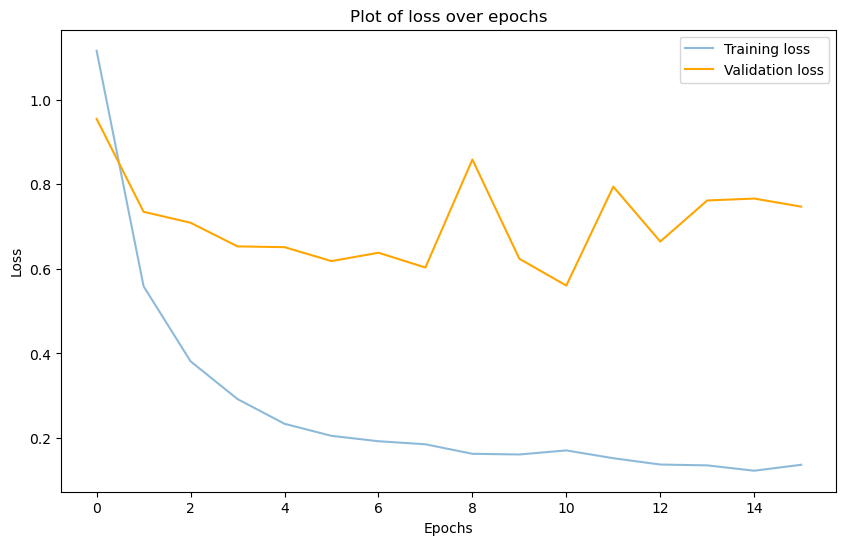

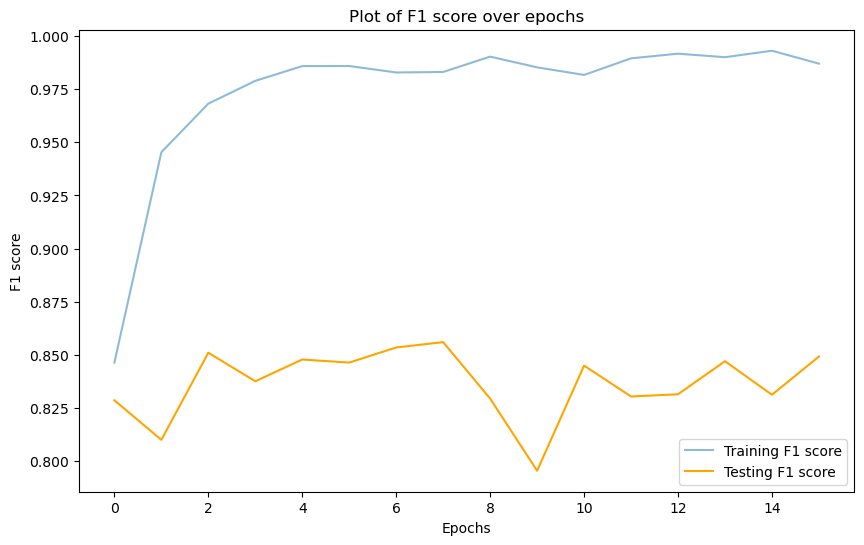

In [99]:
plot_curve(history_l2_mob_netv2)

In [19]:
pickle.dump(history_l2_mob_netv2, open('./weights/l2_mob_netv2_epoch/history_l2_mob_netv2.pkl', 'wb'))

> While the first epoch has some improved scores, from the l2 regularization, only the first epoch is not severely overfit which makes the scores somewhat dubious. While the learning rate can be lowered further or batch size decrease, to improve the scores and help with the overfit, it would is slower to fine tune and other options such as dropout can be explored further to before fine tuning.

### MobileNetV2 with dropout

In [20]:
# Create base model architecture & instantiate empty sequential model
dropout_mob_netv2 = Sequential() 

# Add pre-trained model to use Transfer Learnin (get all the weights from pre_trained_mode)
dropout_mob_netv2.add(mob_netv2) 

# dropout layer
dropout_mob_netv2.add(Dropout(0.5))

# Output layer
dropout_mob_netv2.add(Dense(1, activation= 'sigmoid')) #sigmoid for binary output

# Check model architecture compilation summary
dropout_mob_netv2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
#set callbacks

# Instantiating earlystopping
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.02, 
                           patience = 5, 
                           mode = 'auto'
                          )
# Instantiating checkpoint
checkpoint_callback = ModelCheckpoint(filepath = "./weights/dropout_mob_netv2_epoch/dropout_mob_netv2_epoch_{epoch:02d}_{f1_score:.2f}_{val_f1_score:.2f}.h5",
                                      save_weights_only = False,
                                      save_best_only = False,
                                      save_freq = 'epoch',
                                      verbose = 1
                                      )

In [22]:
epochs = 20

# Compile the model with adam optimizer and specify loss type.
opt = Adam(learning_rate=0.001) 
dropout_mob_netv2.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score()])

# Fit train model with early stopping -> higher epochs
history_dropout_mob_netv2 = dropout_mob_netv2.fit(x = mobnetv2_train_bin_data,
                                                  validation_data = mobnetv2_val_bin_data,
                                                  epochs = epochs,
                                                  batch_size = 32,
                                                  callbacks = [early_stop, checkpoint_callback]
                                                  )

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 0.7243 - f1_score: 0.6754
Epoch 1: saving model to ./weights/dropout_mob_netv2_epoch\dropout_mob_netv2_epoch_01_0.68_0.74.h5
98/98 [==============================] - 67s 659ms/step - loss: 0.7243 - f1_score: 0.6754 - val_loss: 0.5806 - val_f1_score: 0.7442
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.5341 - f1_score: 0.7740
Epoch 2: saving model to ./weights/dropout_mob_netv2_epoch\dropout_mob_netv2_epoch_02_0.77_0.80.h5
98/98 [==============================] - 60s 615ms/step - loss: 0.5341 - f1_score: 0.7740 - val_loss: 0.5567 - val_f1_score: 0.7965
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.4460 - f1_score: 0.8241
Epoch 3: saving model to ./weights/dropout_mob_netv2_epoch\dropout_mob_netv2_epoch_03_0.82_0.81.h5
98/98 [==============================] - 60s 614ms/step - loss: 0.4460 - f1_score: 0.8241 - val_loss: 0.5411 - val_f1_score: 0.8102
Epoch 4/20
98/98 [=======

In [23]:
# pdf the history for quick comparison.
pd.DataFrame(history_dropout_mob_netv2.history, index = pd.RangeIndex(1,len(history_dropout_mob_netv2.history['loss'])+1))

,loss,f1_score,val_loss,val_f1_score
1,0.724334,0.675443,0.580562,0.744235
2,0.534118,0.774036,0.556733,0.796495
3,0.446019,0.824077,0.541116,0.810176
4,0.408647,0.842565,0.521321,0.798395
5,0.379235,0.859813,0.519043,0.803197
6,0.357101,0.869087,0.518579,0.806807
7,0.343510,0.878921,0.531434,0.821463
8,0.335059,0.879206,0.528862,0.817916
9,0.329995,0.882127,0.511070,0.815109


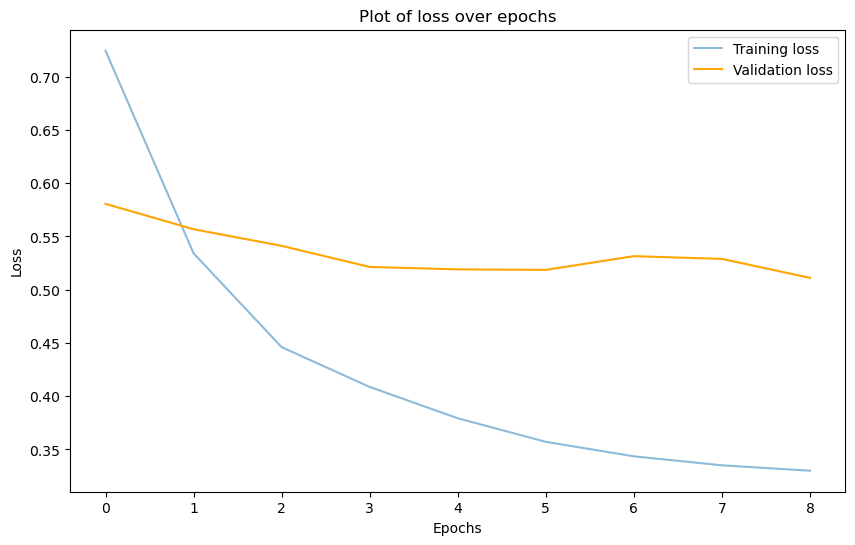

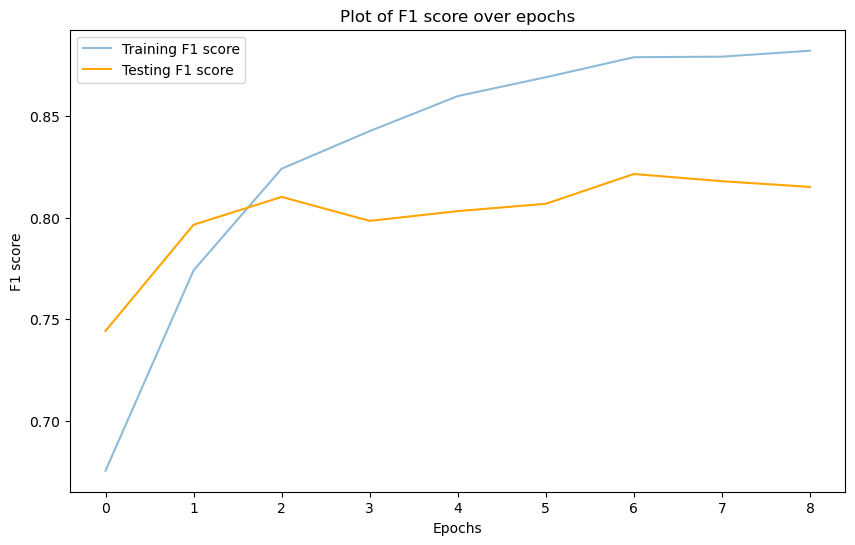

In [100]:
plot_curve(history_dropout_mob_netv2)

In [24]:
pickle.dump(history_dropout_mob_netv2, open('./weights/dropout_mob_netv2_epoch/history_dropout_mob_netv2.pkl', 'wb'))

> With a dropout layer, the model is now taking 2-3 epochs to reach a decent score with lower overfit. However, it expectedly overfits even more after that although it is kept within 10%. Evidently, the dataset being small is impacting it from learning a more generalised model and the variability in class distribution in the validation set happens to be giving it an advantage as compared to the training set resulting in initially higher validation f1 score that quickly drops falls behind.

### MobileNetV2 with l2 regularization and dropout

In [25]:
# Create base model architecture
all_mob_netv2 = Sequential() # instantiate empty sequential model using Sequential class

# Add pre-trained model to use Transfer Learnin (get all the weights from pre_trained_mode)
all_mob_netv2.add(mob_netv2) 

# Add both layers
all_mob_netv2.add(Dense(60, input_dim=1280, activation='relu', kernel_regularizer=l2(0.01)))
all_mob_netv2.add(Dropout(0.5))

# Output layer
all_mob_netv2.add(Dense(1, activation= 'sigmoid')) 

# Compile the model with adam optimizer and specify loss type.
opt = Adam(learning_rate=0.001) 
all_mob_netv2.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score()]) #try multiclass first
#binary_crossentropy can be used for multiclass classification in case an observation can belong to multiple classes at the same time

# Check model architecture compilation summary
all_mob_netv2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, 60)                76860     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 61        
                                                                 
Total params: 2,334,905
Trainable params: 76,921
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
#set callbacks

# Instantiating earlystopping
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.02, 
                           patience = 5, 
                           mode = 'auto'
                          )
# Instantiating checkpoint
checkpoint_callback = ModelCheckpoint(filepath = "./weights/all_mob_netv2_epoch/all_mob_netv2_epoch_{epoch:02d}_{f1_score:.2f}_{val_f1_score:.2f}.h5",
                                      save_weights_only = False,
                                      save_best_only = False,
                                      save_freq = 'epoch',
                                      verbose = 1
                                      )

In [27]:
epochs = 20

# Compile the model with adam optimizer and specify loss type.
opt = Adam(learning_rate=0.001) 
all_mob_netv2.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score()])

# Fit train model with early stopping -> higher epochs
history_all_mob_netv2 = all_mob_netv2.fit(x = mobnetv2_train_bin_data,
                                          validation_data = mobnetv2_val_bin_data,
                                          epochs = epochs,
                                          batch_size = 32,
                                          callbacks = [early_stop, checkpoint_callback]
                                          )

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 1.1942 - f1_score: 0.7962
Epoch 1: saving model to ./weights/all_mob_netv2_epoch\all_mob_netv2_epoch_01_0.80_0.80.h5
98/98 [==============================] - 62s 613ms/step - loss: 1.1942 - f1_score: 0.7962 - val_loss: 0.9976 - val_f1_score: 0.7963
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.6952 - f1_score: 0.8899
Epoch 2: saving model to ./weights/all_mob_netv2_epoch\all_mob_netv2_epoch_02_0.89_0.82.h5
98/98 [==============================] - 60s 610ms/step - loss: 0.6952 - f1_score: 0.8899 - val_loss: 0.7855 - val_f1_score: 0.8248
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.5137 - f1_score: 0.9169
Epoch 3: saving model to ./weights/all_mob_netv2_epoch\all_mob_netv2_epoch_03_0.92_0.83.h5
98/98 [==============================] - 59s 604ms/step - loss: 0.5137 - f1_score: 0.9169 - val_loss: 0.6754 - val_f1_score: 0.8326
Epoch 4/20
98/98 [==============================]

In [28]:
# pdf the history for quick comparison.
pd.DataFrame(history_all_mob_netv2.history, index = pd.RangeIndex(1,len(history_all_mob_netv2.history['loss'])+1))

,loss,f1_score,val_loss,val_f1_score
1,1.194217,0.796247,0.997647,0.796315
2,0.695151,0.889926,0.785538,0.824825
3,0.513748,0.916894,0.675419,0.832627
4,0.431526,0.929204,0.807996,0.831628
5,0.375072,0.940983,0.628452,0.841998
6,0.332076,0.948124,0.609889,0.835913
7,0.309666,0.949078,0.679765,0.842000
8,0.317039,0.941144,0.683881,0.837736
9,0.311953,0.942833,0.643953,0.844400
10,0.294052,0.950729,0.679474,0.832669


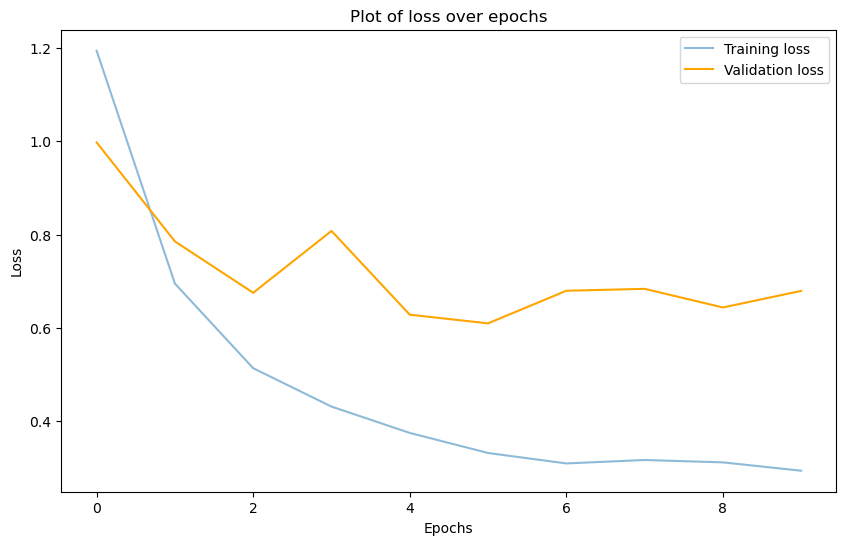

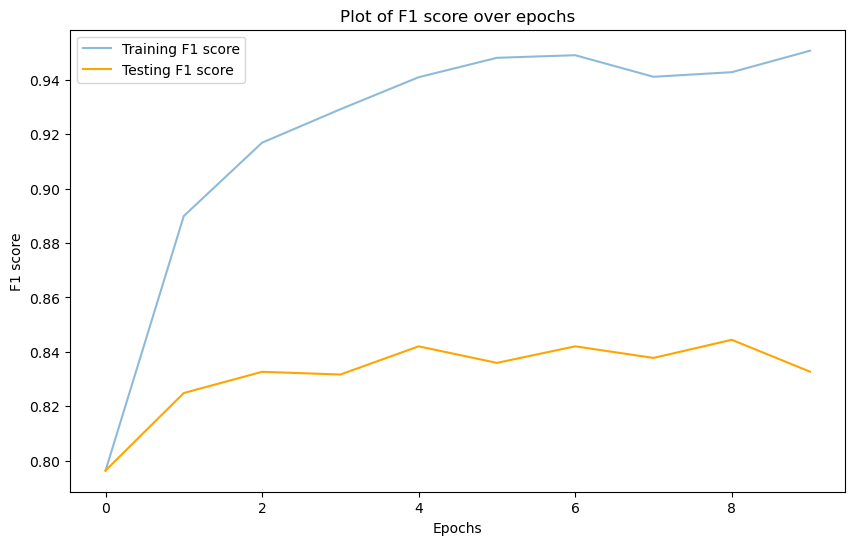

In [101]:
plot_curve(history_all_mob_netv2)

In [29]:
pickle.dump(history_all_mob_netv2, open('./weights/all_mob_netv2_epoch/history_all_mob_netv2.pkl', 'wb'))

> By combining both l2 regularization and dropout, the model is now taking 1-2 epochs to reach a decent score with lower overfit. After which, it expectedly overfits even more although it is the overfit is less severe than before but at the cost of lower scores. after that although it is kept within 10%. Evidently, the dataset being small is impacting it from learning a more generalised model and the variability in class distribution in the validation set happens to be giving it an advantage as compared to the training set resulting in initially higher validation f1 score that quickly drops falls behind.

### MobileNetV2 Combined evaluation

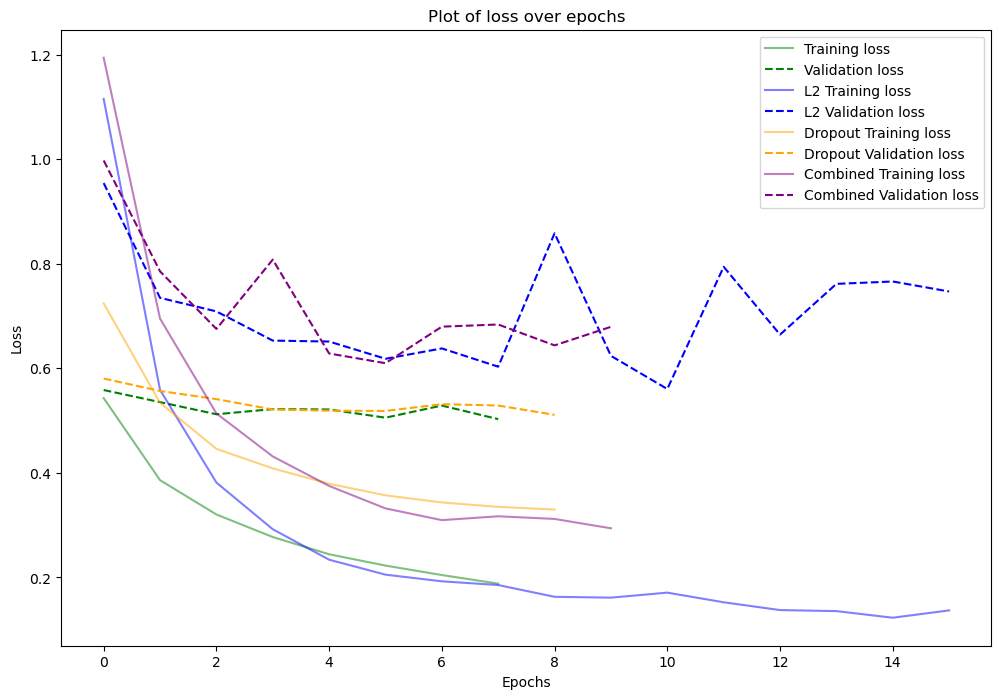

In [30]:
# plot training curves
train_loss_base = history_base_mob_netv2.history['loss']
val_loss_base = history_base_mob_netv2.history['val_loss']
train_loss_l2 = history_l2_mob_netv2.history['loss']
val_loss_l2 = history_l2_mob_netv2.history['val_loss']
train_loss_dropout = history_dropout_mob_netv2.history['loss']
val_loss_dropout = history_dropout_mob_netv2.history['val_loss']
train_loss_all = history_all_mob_netv2.history['loss']
val_loss_all = history_all_mob_netv2.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_base, linestyle = 'solid', color='green', alpha = 0.5, label='Training loss') # plot training loss of original overfit model
plt.plot(val_loss_base, linestyle = 'dashed', color='green', label='Validation loss') # plot val loss of original overfit model
plt.plot(train_loss_l2, linestyle = 'solid', color='blue', alpha = 0.5, label='L2 Training loss') # plot training loss of l2 regularized model
plt.plot(val_loss_l2, linestyle = 'dashed', color='blue', label='L2 Validation loss') # plot val loss of l2 regularized model
plt.plot(train_loss_dropout, linestyle = 'solid', color='orange', alpha = 0.5, label='Dropout Training loss') # plot training loss of dropout model
plt.plot(val_loss_dropout, linestyle = 'dashed', color='orange', label='Dropout Validation loss') # plot val loss of dropout model
plt.plot(train_loss_all, linestyle = 'solid', color='purple', alpha = 0.5, label='Combined Training loss') # plot training loss of all model
plt.plot(val_loss_all, linestyle = 'dashed', color='purple', label='Combined Validation loss') # plot val loss of all model
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of loss over epochs')
plt.legend();

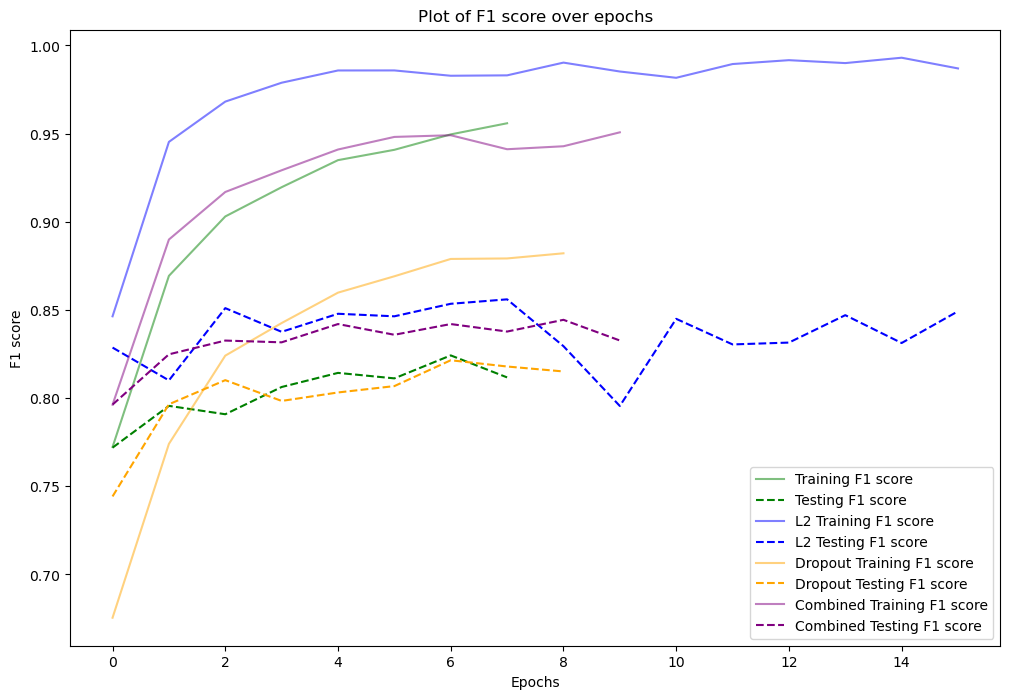

In [31]:
# plot training curves
train_f1_base = history_base_mob_netv2.history['f1_score']
val_f1_base = history_base_mob_netv2.history['val_f1_score']
train_f1_l2 = history_l2_mob_netv2.history['f1_score']
val_f1_l2 = history_l2_mob_netv2.history['val_f1_score']
train_f1_dropout = history_dropout_mob_netv2.history['f1_score']
val_f1_dropout = history_dropout_mob_netv2.history['val_f1_score']
train_f1_all = history_all_mob_netv2.history['f1_score']
val_f1_all = history_all_mob_netv2.history['val_f1_score']

plt.figure(figsize=(12, 8))
plt.plot(train_f1_base, linestyle = 'solid', color='green', alpha = 0.5, label = 'Training F1 score') # plot training f1 of original overfit model
plt.plot(val_f1_base, linestyle = 'dashed', color='green', label = 'Testing F1 score') # plot testing f1 of original overfit model
plt.plot(train_f1_l2, linestyle = 'solid', color='blue', alpha = 0.5, label = 'L2 Training F1 score') # plot training f1 of l2 regularized model
plt.plot(val_f1_l2, linestyle = 'dashed', color='blue', label = 'L2 Testing F1 score') # plot testing f1 of l2 regularized model
plt.plot(train_f1_dropout, linestyle = 'solid', color='orange', alpha = 0.5, label = 'Dropout Training F1 score') # plot training f1 of dropout model
plt.plot(val_f1_dropout, linestyle = 'dashed', color='orange', label = 'Dropout Testing F1 score') # plot testing f1 of dropout model
plt.plot(train_f1_all, linestyle = 'solid', color='purple', alpha = 0.5, label = 'Combined Training F1 score') # plot training f1 of all model
plt.plot(val_f1_all, linestyle = 'dashed', color='purple', label = 'Combined Testing F1 score') # plot testing loss of all model
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.title('Plot of F1 score over epochs')
plt.legend();

> From the above graphs, it seems that l2 (blue) does not help to reduce overfit as well as the dropout (orange) since the loss gap between train and validation does not reduce as much. In fact, dropout seems to penalise the training scores more since it starts off the lowest even though it quickly climbs back up. The gap between the train and validation scores have a smaller gap than the other models, indicating lower overfit. Thus, the model architecture with dropout seems to be more effective in this case and should be the point of focus after establishing a baseline with a new model.
> 
> Though MobileNetV2 has an okay score of around 70-80%, there is still room for improvement and as mentioned earlier, other model architectures such as MobilenetV3, EfficientNet and Resnet can still be explore.


## MobileNetV3 transfer model

1. Direct application of pretrain model with sigmoid output layer, early stopping enabled.
2. Pretrain model with dropout layer, sigmoid output layer, early stopping enabled.

### Reimport augmented data

> Due to the requirements of the pretrain models, the images will be loaded as 224X224 even though the original data size is 200X200.

In [32]:
from tensorflow.keras.applications import MobileNetV3Large

In [33]:
# Load the Train and Validation data
mobnetv3_train_bin_data = ImageDataGenerator().flow_from_directory(train_bin_folder, 
                                                                   target_size= (224,224), 
                                                                   batch_size= 32,
                                                                   class_mode= 'binary',
                                                                   seed = 42,
                                                                   shuffle=True
                                                                   )

mobnetv3_val_bin_data = ImageDataGenerator().flow_from_directory(val_bin_folder, 
                                                                 target_size=(224,224), 
                                                                 class_mode='binary',
                                                                 seed = 42,
                                                                 shuffle=True
                                                                 )

Found 3119 images belonging to 2 classes.
Found 799 images belonging to 2 classes.


In [34]:
# Check the classes that ImageDataGenerator was able to find using .class_indices
class_mappings = mobnetv3_train_bin_data.class_indices 
print(class_mappings) 

{'0_non': 0, '1_recyclable': 1}


In [35]:
# Import the MobileNetV3 pre-trained transfer learning model
mob_netv3l = MobileNetV3Large(input_shape= (224, 224, 3),
                              include_top=False, 
                              pooling='avg', 
                              dropout_rate=0.2,            #default
                              include_preprocessing = True #default, hence removed from ImageDataGenerator
                             )

# Freeze the model to prevent changes to the pre-trained model parameters during dense layer gradient descent
mob_netv3l.trainable = False

### MobileNetV3 base model

In [36]:
# Create base model architecture & instantiate empty sequential model
base_mob_netv3l = Sequential() 

# Add pre-trained model to use Transfer Learnin (get all the weights from pre_trained_mode)
base_mob_netv3l.add(mob_netv3l) 

# Output layer
base_mob_netv3l.add(Dense(1, activation= 'sigmoid')) #sigmoid for binary output

# Check model architecture compilation summary
base_mob_netv3l.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________


In [37]:
#set callbacks

# Instantiating earlystopping
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.02, 
                           patience = 5, 
                           mode = 'auto'
                          )
# Instantiating checkpoint
checkpoint_callback = ModelCheckpoint(filepath = "./weights/base_mob_netv3l_epoch/base_mob_netv3l_epoch_{epoch:02d}_{f1_score:.2f}_{val_f1_score:.2f}.h5",
                                      save_weights_only = False,
                                      save_best_only = False,
                                      save_freq = 'epoch',
                                      verbose = 1
                                      )

In [38]:
epochs = 20

# Compile the model with adam optimizer and specify loss type.
opt = Adam(learning_rate=0.001) 
base_mob_netv3l.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score()])

# Fit train model with early stopping -> higher epochs
history_base_mob_netv3l = base_mob_netv3l.fit(x = mobnetv3_train_bin_data,
                                              validation_data = mobnetv3_val_bin_data,
                                              epochs = epochs,
                                              batch_size = 32,
                                              callbacks = [early_stop, checkpoint_callback]
                                              )

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 0.5974 - f1_score: 0.7390
Epoch 1: saving model to ./weights/base_mob_netv3l_epoch\base_mob_netv3l_epoch_01_0.74_0.74.h5
98/98 [==============================] - 62s 604ms/step - loss: 0.5974 - f1_score: 0.7390 - val_loss: 0.5755 - val_f1_score: 0.7386
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.4374 - f1_score: 0.8327
Epoch 2: saving model to ./weights/base_mob_netv3l_epoch\base_mob_netv3l_epoch_02_0.83_0.77.h5
98/98 [==============================] - 59s 602ms/step - loss: 0.4374 - f1_score: 0.8327 - val_loss: 0.5433 - val_f1_score: 0.7722
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.3781 - f1_score: 0.8633
Epoch 3: saving model to ./weights/base_mob_netv3l_epoch\base_mob_netv3l_epoch_03_0.86_0.79.h5
98/98 [==============================] - 59s 600ms/step - loss: 0.3781 - f1_score: 0.8633 - val_loss: 0.5388 - val_f1_score: 0.7917
Epoch 4/20
98/98 [===================

In [39]:
# pdf the history for quick comparison.
pd.DataFrame(history_base_mob_netv3l.history, index = pd.RangeIndex(1,len(history_base_mob_netv3l.history['loss'])+1))

,loss,f1_score,val_loss,val_f1_score
1,0.597440,0.738994,0.575538,0.738562
2,0.437409,0.832660,0.543323,0.772152
3,0.378096,0.863340,0.538780,0.791710
4,0.332280,0.889913,0.541631,0.796353
5,0.303238,0.900601,0.536066,0.795918
6,0.277154,0.913689,0.538880,0.790174
7,0.256540,0.927608,0.539493,0.789796


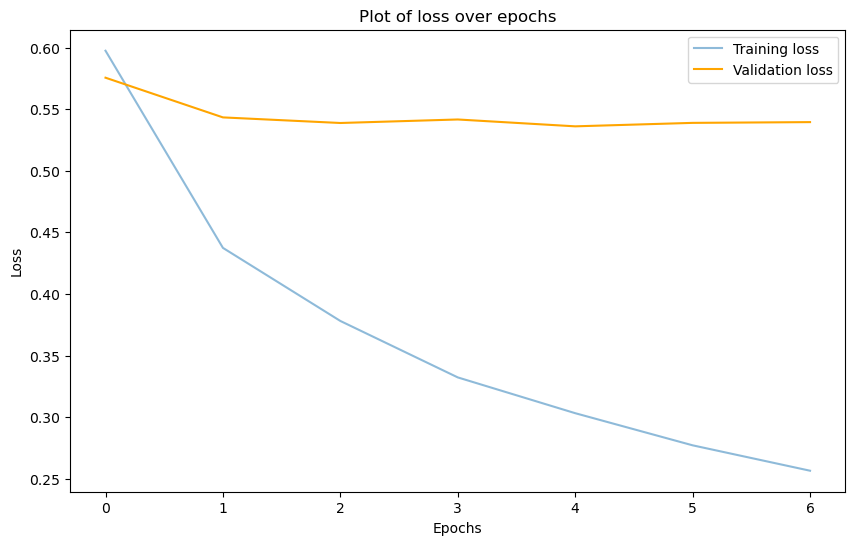

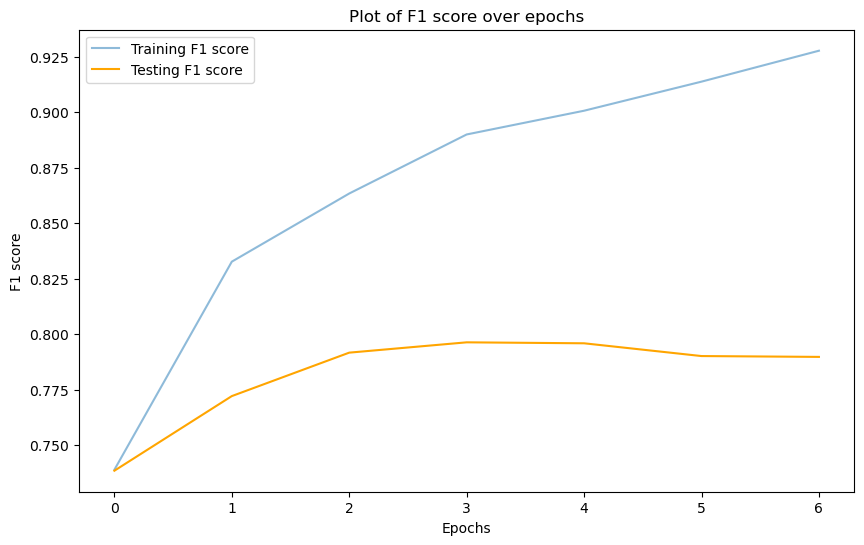

In [87]:
plot_curve(history_base_mob_netv3l)

In [40]:
pickle.dump(history_base_mob_netv3l, open('./weights/base_mob_netv3l_epoch/history_base_mob_netv3l.pkl', 'wb'))

| Model       | Epoch | F1 train | F1 val |
|-------------|-------|----------|--------|
| MobileNetV2 | 1     | 0.7722   | 0.7719 |
| MobileNetV3 | 1     | 0.6754   | 0.7442 |
| MobileNetV2 | 2     | 0.8693   | 0.7956 |
| MobileNetV3 | 2     | 0.8327   | 0.7722 |

> While the initial val_f1_score if 74.4% is lower than the MobileNetV2 val_f1_score of 77.2%, the subsequent overfitting has been reduced from about 7% to 6%. Likely this is due to the default dropout rate of 0.2 specified in MobileNetV3.
>
> While this is not ideal, this indicates that the newer version of the MobileNet does have some improvements that reduced overfit and hence allows for the model to be trained longer and achieve a better fit. Based on this and the earlier information and the earlier V2 model with dropout that gave better scores and lower overfitting, dropout may be the better options in trying to reduce the overfit.

### MobileNetV3 with dropout

In [147]:
# Create base model architecture & instantiate empty sequential model
dropout_mob_netv3l = Sequential() 

# Add pre-trained model to use Transfer Learnin (get all the weights from pre_trained_mode)
dropout_mob_netv3l.add(mob_netv3l) 

#addtional dropout layer
dropout_mob_netv3l.add(Dropout(0.5)) #even though there is a default 0.2 dropout, further dropout may help to reduce the overfit further.

# Output layer
dropout_mob_netv3l.add(Dense(1, activation= 'sigmoid')) #sigmoid for binary output

# Check model architecture compilation summary
dropout_mob_netv3l.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout_7 (Dropout)         (None, 960)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________


In [148]:
#set callbacks

# Instantiating earlystopping
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.02, 
                           patience = 5, 
                           mode = 'auto'
                          )
# Instantiating checkpoint
checkpoint_callback = ModelCheckpoint(filepath = "./weights/full_dropout_mob_netv3l_epoch/dropout_mob_netv3l_epoch_{epoch:02d}_{f1_score:.2f}_{val_f1_score:.2f}.h5",
                                      save_weights_only = False,
                                      save_best_only = False,
                                      save_freq = 'epoch',
                                      verbose = 1
                                      )

In [149]:
epochs = 20

# Compile the model with adam optimizer and specify loss type.
opt = Adam(learning_rate=0.001) 
dropout_mob_netv3l.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score()])

# Fit train model with early stopping -> higher epochs
history_dropout_mob_netv3l = dropout_mob_netv3l.fit(x = mobnetv3_train_bin_data,
                                              validation_data = mobnetv3_val_bin_data,
                                              epochs = epochs,
                                              batch_size = 32,
                                              callbacks = [early_stop, checkpoint_callback]
                                              )

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 0.7858 - f1_score: 0.6518
Epoch 1: saving model to ./weights/full_dropout_mob_netv3l_epoch\dropout_mob_netv3l_epoch_01_0.65_0.75.h5
98/98 [==============================] - 68s 647ms/step - loss: 0.7858 - f1_score: 0.6518 - val_loss: 0.5621 - val_f1_score: 0.7484
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.5994 - f1_score: 0.7307
Epoch 2: saving model to ./weights/full_dropout_mob_netv3l_epoch\dropout_mob_netv3l_epoch_02_0.73_0.77.h5
98/98 [==============================] - 59s 605ms/step - loss: 0.5994 - f1_score: 0.7307 - val_loss: 0.5358 - val_f1_score: 0.7654
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.5145 - f1_score: 0.7771
Epoch 3: saving model to ./weights/full_dropout_mob_netv3l_epoch\dropout_mob_netv3l_epoch_03_0.78_0.78.h5
98/98 [==============================] - 59s 602ms/step - loss: 0.5145 - f1_score: 0.7771 - val_loss: 0.5095 - val_f1_score: 0.7791
Epoc

In [150]:
# pdf the history for quick comparison.
pd.DataFrame(history_dropout_mob_netv3l.history, index = pd.RangeIndex(1,len(history_dropout_mob_netv3l.history['loss'])+1))

,loss,f1_score,val_loss,val_f1_score
1,0.785766,0.651832,0.562076,0.748428
2,0.599382,0.730665,0.535845,0.765381
3,0.514542,0.777112,0.509492,0.779082
4,0.478438,0.800325,0.522586,0.789474
5,0.450005,0.813115,0.506860,0.808598
6,0.427248,0.829654,0.532278,0.800391
7,0.407632,0.845086,0.528448,0.807122
8,0.399587,0.846154,0.516275,0.808333


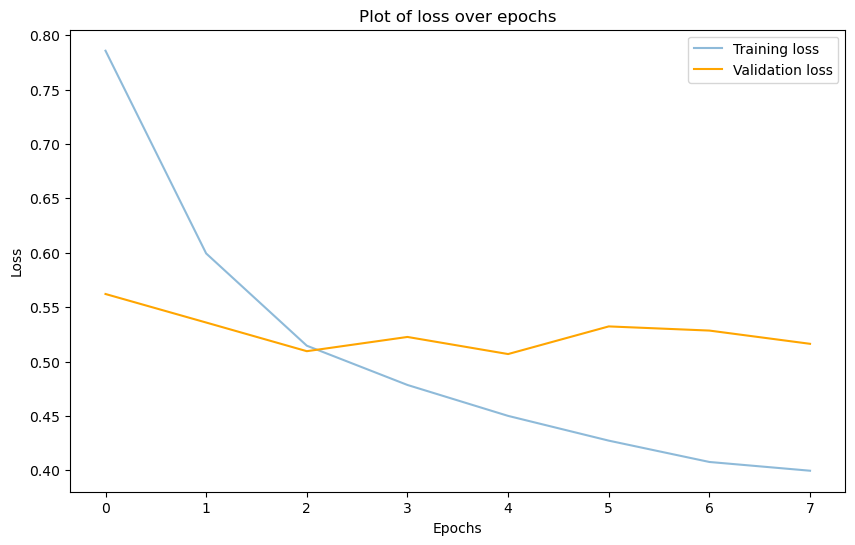

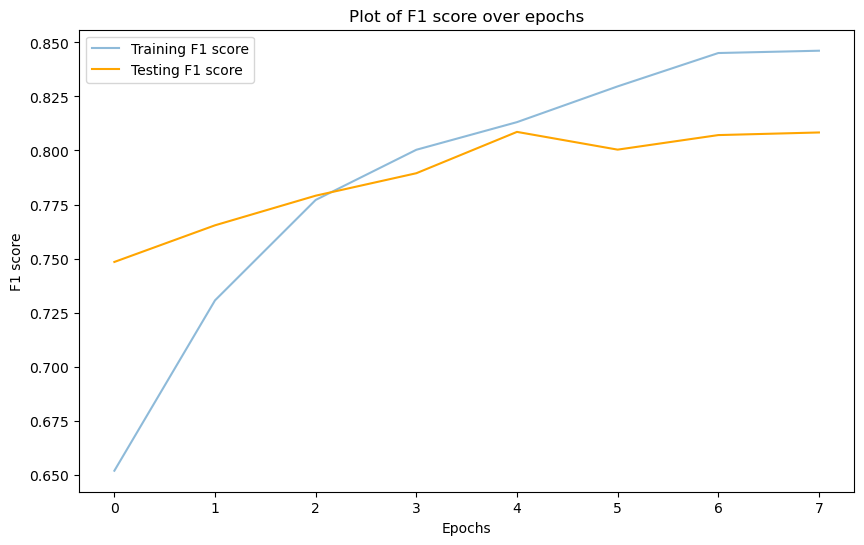

In [96]:
plot_curve(history_dropout_mob_netv3l)

In [151]:
pickle.dump(history_dropout_mob_netv3l, open('./weights/full_dropout_mob_netv3l_epoch/history_dropout_mob_netv3l.pkl', 'wb'))

| Model                 | Epoch | F1 train | F1 val |
|-----------------------|-------|----------|--------|
| MobileNetV3           | 2     | 0.8327   | 0.7722 |
| MobileNetV3 + dropout | 5     | 0.8131   | 0.8086 |

>With the additional dropout layer, the overfit has been reduced significantly from 6% to 0.5% allowing for the validation score achieved at 80.9% which is higher than just the base model of 77.2%. The weights at epoch 5 of this model architecture would be the scores to beat.

> While MobileNetV3 has an okay score of around 80%, there is still room for improvement. Since MobileNet is a more resource light and computationally less intensive, this could come at the expense of accuracy since the model is not able to learn as deeply. Thus, as mentioned earlier, it is good to explore other model with higher accuracies such as EfficientNet ResNe.


## EfficientV2M net transfer model
1. Direct application of pretrain model with sigmoid output layer, early stopping enabled.
2. Pretrain model with dropout layer, sigmoid output layer, early stopping enabled.

### Reimport augmented data

> Due to the requirements of the pretrain models, the images will be loaded as 224X224 even though the original data size is 200X200.

In [41]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M

In [42]:
# Load the Train and Validation data
effnetv2_train_bin_data = ImageDataGenerator().flow_from_directory(train_bin_folder, 
                                                                   target_size= (224,224), 
                                                                   batch_size= 32,
                                                                   class_mode= 'binary',
                                                                   seed = 42,
                                                                   shuffle=True
                                                                   )

effnetv2_val_bin_data = ImageDataGenerator().flow_from_directory(val_bin_folder, 
                                                                 target_size=(224,224), 
                                                                 class_mode='binary',
                                                                 seed = 42,
                                                                 shuffle=True
                                                                 )

Found 3119 images belonging to 2 classes.
Found 799 images belonging to 2 classes.


In [43]:
# Check the classes that ImageDataGenerator was able to find using .class_indices
class_mappings = effnetv2_train_bin_data.class_indices 
print(class_mappings) 

{'0_non': 0, '1_recyclable': 1}


In [44]:
# Import the MobileNetV3 pre-trained transfer learning model
eff_netv2m = EfficientNetV2M(input_shape= (224, 224, 3),
                             include_top=False, 
                             pooling='avg', 
                             include_preprocessing = True #default, hence removed from ImageDataGenerator
                             )

# Freeze the model to prevent changes to the pre-trained model parameters during dense layer gradient descent
eff_netv2m.trainable = False

### EfficientNetV2M base model

In [45]:
# Create base model architecture & instantiate empty sequential model
base_eff_netv2m = Sequential() 

# Add pre-trained model to use Transfer Learnin (get all the weights from pre_trained_mode)
base_eff_netv2m.add(eff_netv2m) 

# Output layer
base_eff_netv2m.add(Dense(1, activation= 'sigmoid')) #sigmoid for binary output

# Check model architecture compilation summary
base_eff_netv2m.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 53,151,669
Trainable params: 1,281
Non-trainable params: 53,150,388
_________________________________________________________________


In [46]:
#set callbacks

# Instantiating earlystopping
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.02, 
                           patience = 5, 
                           mode = 'auto'
                          )
# Instantiating checkpoint
checkpoint_callback = ModelCheckpoint(filepath = "./weights/base_eff_netv2m_epoch/base_eff_netv2m_epoch_{epoch:02d}_{f1_score:.2f}_{val_f1_score:.2f}.h5",
                                      save_weights_only = False,
                                      save_best_only = False,
                                      save_freq = 'epoch',
                                      verbose = 1
                                      )

In [47]:
epochs = 20

# Compile the model with adam optimizer and specify loss type.
opt = Adam(learning_rate=0.001) 
base_eff_netv2m.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score()])

# Fit train model with early stopping -> higher epochs
history_base_eff_netv2m = base_eff_netv2m.fit(x = effnetv2_train_bin_data,
                                              validation_data = effnetv2_val_bin_data,
                                              epochs = epochs,
                                              batch_size = 32,
                                              callbacks = [early_stop, checkpoint_callback]
                                              )

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 0.6130 - f1_score: 0.7409
Epoch 1: saving model to ./weights/base_eff_netv2m_epoch\base_eff_netv2m_epoch_01_0.74_0.78.h5
98/98 [==============================] - 448s 4s/step - loss: 0.6130 - f1_score: 0.7409 - val_loss: 0.5554 - val_f1_score: 0.7789
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.5255 - f1_score: 0.7962
Epoch 2: saving model to ./weights/base_eff_netv2m_epoch\base_eff_netv2m_epoch_02_0.80_0.80.h5
98/98 [==============================] - 434s 4s/step - loss: 0.5255 - f1_score: 0.7962 - val_loss: 0.5294 - val_f1_score: 0.8032
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.4819 - f1_score: 0.8222
Epoch 3: saving model to ./weights/base_eff_netv2m_epoch\base_eff_netv2m_epoch_03_0.82_0.79.h5
98/98 [==============================] - 428s 4s/step - loss: 0.4819 - f1_score: 0.8222 - val_loss: 0.5204 - val_f1_score: 0.7895
Epoch 4/20
98/98 [=========================

In [48]:
# pdf the history for quick comparison.
pd.DataFrame(history_base_eff_netv2m.history, index = pd.RangeIndex(1,len(history_base_eff_netv2m.history['loss'])+1))

,loss,f1_score,val_loss,val_f1_score
1,0.612992,0.740950,0.555449,0.778926
2,0.525505,0.796168,0.529431,0.803245
3,0.481861,0.822234,0.520396,0.789474
4,0.455341,0.825141,0.513313,0.794355
5,0.432422,0.841644,0.511053,0.789579
6,0.415166,0.849404,0.508142,0.788321
7,0.404300,0.845689,0.509975,0.795635
8,0.392627,0.846489,0.506784,0.794268
9,0.385188,0.859006,0.501716,0.789418
10,0.378206,0.864583,0.500873,0.784399


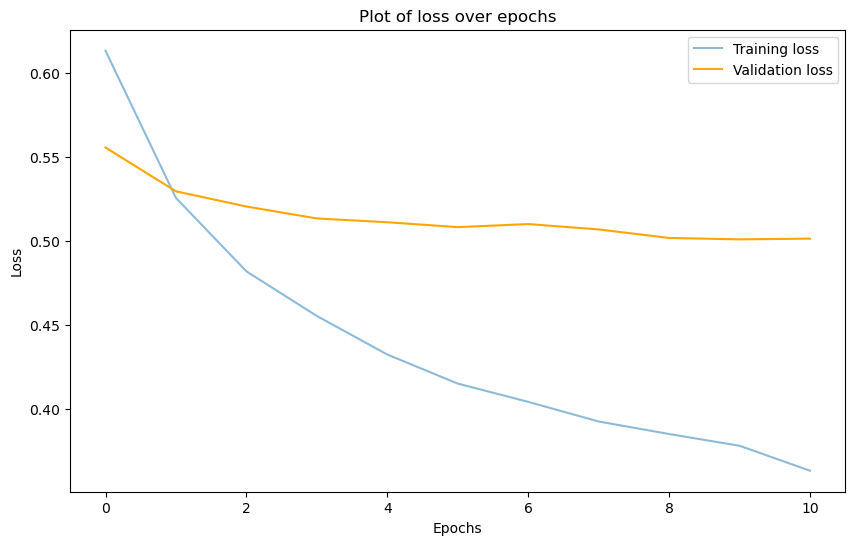

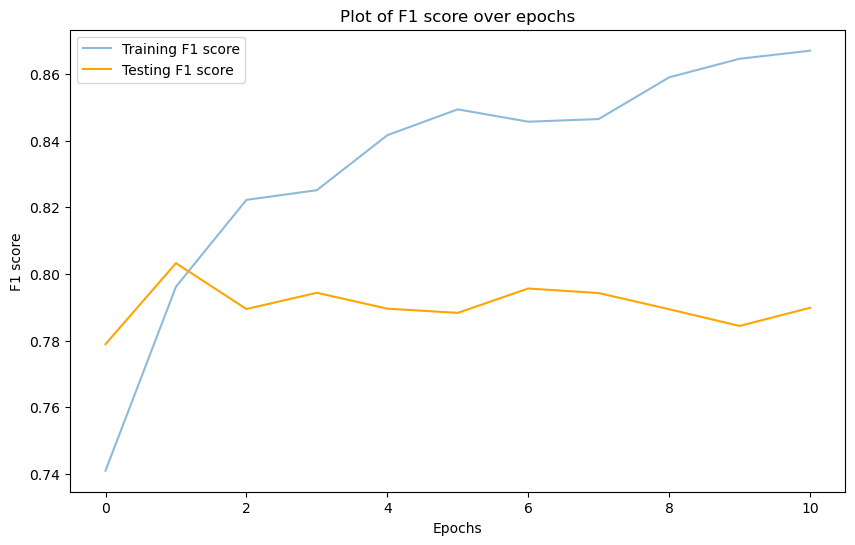

In [88]:
plot_curve(history_base_eff_netv2m)

In [49]:
pickle.dump(history_base_eff_netv2m, open('./weights/base_eff_netv2m_epoch/history_base_eff_netv2m.pkl', 'wb'))

| Model                 | Epoch | F1 train | F1 val |
|-----------------------|-------|----------|--------|
| MobileNetV3 + dropout | 5     | 0.8131   | 0.8086 |
| EfficientNetV2M       | 4     | 0.8251   | 0.7944 |

> The val_f1_score of 79.4% is slightly lower than the MobileNetV2 val_f1_score of 80.9%, and the overfitting is actually higher at 3.1%. Likely this is due to there being no dropout specified for this particular architecture.
> To make the comparison more fair, a drop out layer needs to be introduced.

### EfficientNetV2M model with dropout

In [179]:
# Create base model architecture & instantiate empty sequential model
dropout_eff_netv2m = Sequential() 

# Add pre-trained model to use Transfer Learnin (get all the weights from pre_trained_mode)
dropout_eff_netv2m.add(eff_netv2m) 

#addtional dropout layer
dropout_eff_netv2m.add(Dropout(0.5))

# Output layer
dropout_eff_netv2m.add(Dense(1, activation= 'sigmoid')) #sigmoid for binary output

# Check model architecture compilation summary
dropout_eff_netv2m.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_21 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 53,151,669
Trainable params: 1,281
Non-trainable params: 53,150,388
_________________________________________________________________


In [181]:
#set callbacks

# Instantiating earlystopping
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.02, 
                           patience = 5, 
                           mode = 'auto'
                          )
# Instantiating checkpoint
checkpoint_callback = ModelCheckpoint(filepath = "./weights/dropout_eff_netv2m_epoch/dropout_eff_netv2m_epoch_{epoch:02d}_{f1_score:.2f}_{val_f1_score:.2f}.h5",
                                      save_weights_only = False,
                                      save_best_only = False,
                                      save_freq = 'epoch',
                                      verbose = 1
                                      )

In [182]:
epochs = 20

# Compile the model with adam optimizer and specify loss type.
opt = Adam(learning_rate=0.001) 
dropout_eff_netv2m.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score()])

# Fit train model with early stopping -> higher epochs
history_dropout_eff_netv2m = dropout_eff_netv2m.fit(x = effnetv2_train_bin_data,
                                                    validation_data = effnetv2_val_bin_data,
                                                    epochs = epochs,
                                                    batch_size = 32,
                                                    callbacks = [early_stop, checkpoint_callback]
                                                    )

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 0.6610 - f1_score: 0.6756
Epoch 1: saving model to ./weights/dropout_eff_netv2m_epoch\dropout_eff_netv2m_epoch_01_0.68_0.76.h5
98/98 [==============================] - 513s 5s/step - loss: 0.6610 - f1_score: 0.6756 - val_loss: 0.5863 - val_f1_score: 0.7591
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.5728 - f1_score: 0.7563
Epoch 2: saving model to ./weights/dropout_eff_netv2m_epoch\dropout_eff_netv2m_epoch_02_0.76_0.79.h5
98/98 [==============================] - 497s 5s/step - loss: 0.5728 - f1_score: 0.7563 - val_loss: 0.5523 - val_f1_score: 0.7912
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.5390 - f1_score: 0.7719
Epoch 3: saving model to ./weights/dropout_eff_netv2m_epoch\dropout_eff_netv2m_epoch_03_0.77_0.78.h5
98/98 [==============================] - 500s 5s/step - loss: 0.5390 - f1_score: 0.7719 - val_loss: 0.5336 - val_f1_score: 0.7837
Epoch 4/20
98/98 [=======

In [124]:
# pdf the history for quick comparison.
pd.DataFrame(history_dropout_eff_netv2m.history, index = pd.RangeIndex(1,len(history_dropout_eff_netv2m.history['loss'])+1))

,loss,f1_score,val_loss,val_f1_score
1,0.639183,0.688507,0.568971,0.766129
2,0.562640,0.767239,0.536494,0.777894
3,0.531281,0.778375,0.523287,0.791795
4,0.513769,0.791340,0.521591,0.780992
5,0.499066,0.801189,0.516008,0.784033
6,0.473517,0.809949,0.512899,0.784114
7,0.470404,0.808684,0.506944,0.783069
8,0.446125,0.825980,0.508040,0.800000
9,0.458298,0.811665,0.502935,0.802030
10,0.451667,0.815401,0.497432,0.784969


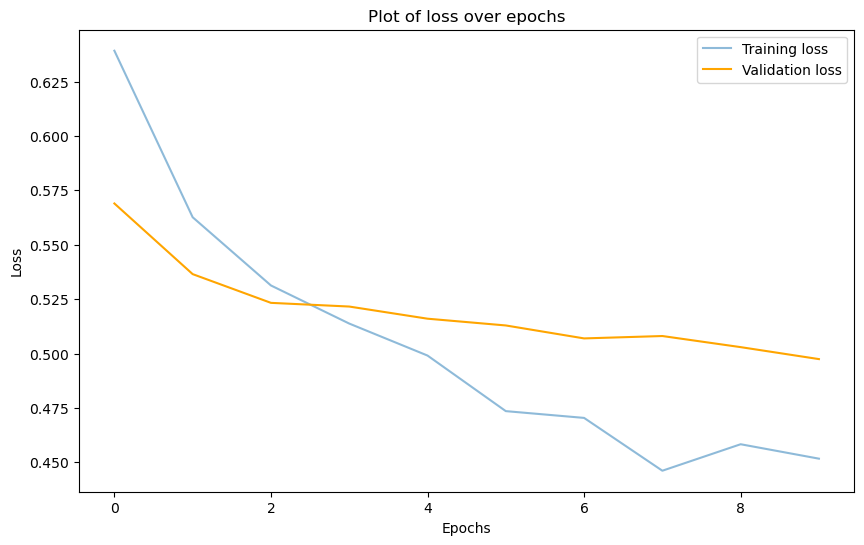

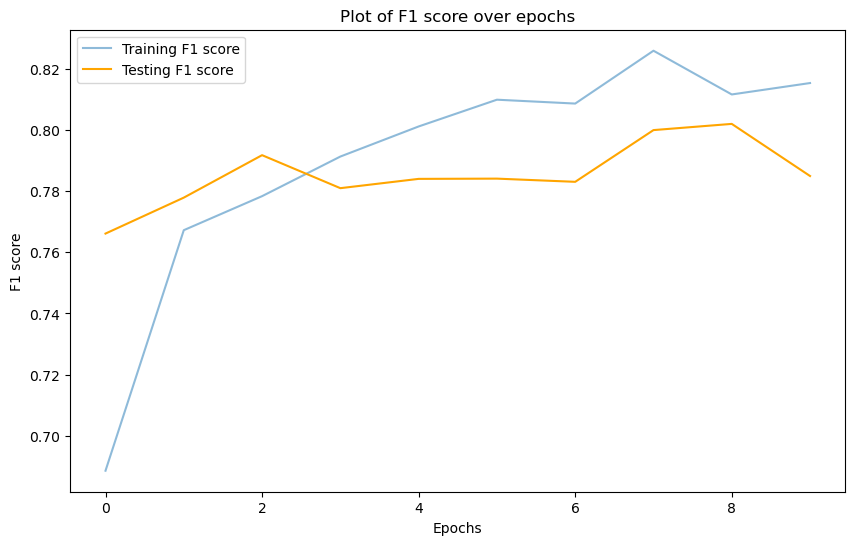

In [97]:
plot_curve(history_dropout_eff_netv2m)

In [102]:
pickle.dump(history_dropout_eff_netv2m, open('./weights/dropout_eff_netv2m_epoch/history_dropout_eff_netv2m.pkl', 'wb'))

| Model                      | Epoch | F1 train | F1 val |
|----------------------------|-------|----------|--------|
| MobileNetV3 + dropout      | 5     | 0.8131   | 0.8086 |
| EfficientNetV2M + dropout  | 9     | 0.8117   | 0.8020 |

> With an additional dropout layer, EfficientNetV2M has a minimally lower score by 0.6%. However, the training score of 81.2% achieved is lower than MobileNetV3 (81.3%) by 0.2%. While, dropout has reduced overfitting from the base model, there is still a higher overfit (at 1%) than MobileNetV3 (at 0.5%).
> Nevertheless, both models are very similar in terms of score and overfit percentages only difference being that EfficcientNetV2M trained over more epochs than MobileNetV3
8020 |

## Resnet50 transfer model
1. Direct application of pretrain model with sigmoid output layer, early stopping enabled.
2. Pretrain model with dropout layer, sigmoid output layer, early stopping enabled.

### Reimport augmented data

> Due to the requirements of the pretrain models, the images will be loaded as 224X224 even though the original data size is 200X200.

In [50]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess_input

In [51]:
# Load the Train and Validation data
resnet_train_bin_data = ImageDataGenerator(preprocessing_function = resnet_preprocess_input).flow_from_directory(
    train_bin_folder, 
    target_size= (224,224), 
    batch_size= 32,
    class_mode= 'binary',
    seed = 42,
    shuffle=True
    )

resnet_val_bin_data = ImageDataGenerator(preprocessing_function=resnet_preprocess_input).flow_from_directory(
    val_bin_folder, 
    target_size=(224,224), 
    class_mode='binary',
    seed = 42,
    shuffle=True
    )

Found 3119 images belonging to 2 classes.
Found 799 images belonging to 2 classes.


In [52]:
# Check the classes that ImageDataGenerator was able to find using .class_indices
class_mappings = resnet_train_bin_data.class_indices 
print(class_mappings) 

{'0_non': 0, '1_recyclable': 1}


In [53]:
# Import the MobileNetV3 pre-trained transfer learning model
res_net = ResNet50(input_shape= (224, 224, 3),
                   include_top=False, 
                   pooling='avg', 
                   )

# Freeze the model to prevent changes to the pre-trained model parameters during dense layer gradient descent
res_net.trainable = False

### Resnet50 base model

In [54]:
# Create base model architecture & instantiate empty sequential model
base_res_net = Sequential() 

# Add pre-trained model to use Transfer Learnin (get all the weights from pre_trained_mode)
base_res_net.add(res_net) 

# Output layer
base_res_net.add(Dense(1, activation= 'sigmoid')) #sigmoid for binary output

# Check model architecture compilation summary
base_res_net.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_8 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [55]:
#set callbacks

# Instantiating earlystopping
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.02, 
                           patience = 5, 
                           mode = 'auto'
                          )
# Instantiating checkpoint
checkpoint_callback = ModelCheckpoint(filepath = "./weights/base_res_net_epoch/base_res_net_epoch_{epoch:02d}_{f1_score:.2f}_{val_f1_score:.2f}.h5",
                                      save_weights_only = False,
                                      save_best_only = False,
                                      save_freq = 'epoch',
                                      verbose = 1
                                      )

In [56]:
epochs = 20

# Compile the model with adam optimizer and specify loss type.
opt = Adam(learning_rate=0.001) 
base_res_net.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score()])

# Fit train model with early stopping -> higher epochs
history_base_res_net = base_res_net.fit(x = resnet_train_bin_data,
                                              validation_data = resnet_val_bin_data,
                                              epochs = epochs,
                                              batch_size = 32,
                                              callbacks = [early_stop, checkpoint_callback]
                                              )

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 0.5672 - f1_score: 0.7545
Epoch 1: saving model to ./weights/base_res_net_epoch\base_res_net_epoch_01_0.75_0.73.h5
98/98 [==============================] - 224s 2s/step - loss: 0.5672 - f1_score: 0.7545 - val_loss: 0.5637 - val_f1_score: 0.7285
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.3752 - f1_score: 0.8777
Epoch 2: saving model to ./weights/base_res_net_epoch\base_res_net_epoch_02_0.88_0.74.h5
98/98 [==============================] - 219s 2s/step - loss: 0.3752 - f1_score: 0.8777 - val_loss: 0.5333 - val_f1_score: 0.7439
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.3004 - f1_score: 0.9107
Epoch 3: saving model to ./weights/base_res_net_epoch\base_res_net_epoch_03_0.91_0.77.h5
98/98 [==============================] - 220s 2s/step - loss: 0.3004 - f1_score: 0.9107 - val_loss: 0.5165 - val_f1_score: 0.7657
Epoch 4/20
98/98 [==============================] - ETA: 0s -

In [57]:
# pdf the history for quick comparison.
pd.DataFrame(history_base_res_net.history, index = pd.RangeIndex(1,len(history_base_res_net.history['loss'])+1))

,loss,f1_score,val_loss,val_f1_score
1,0.567205,0.754478,0.563695,0.728492
2,0.375181,0.877729,0.533314,0.743875
3,0.300384,0.910744,0.516484,0.765727
4,0.255506,0.933074,0.531117,0.814371
5,0.220784,0.947807,0.509283,0.812757
6,0.193553,0.955599,0.585996,0.823984
7,0.174299,0.962942,0.520425,0.818461
8,0.154517,0.968156,0.539361,0.821974
9,0.146423,0.969055,0.579261,0.834990
10,0.130056,0.977146,0.578643,0.833667


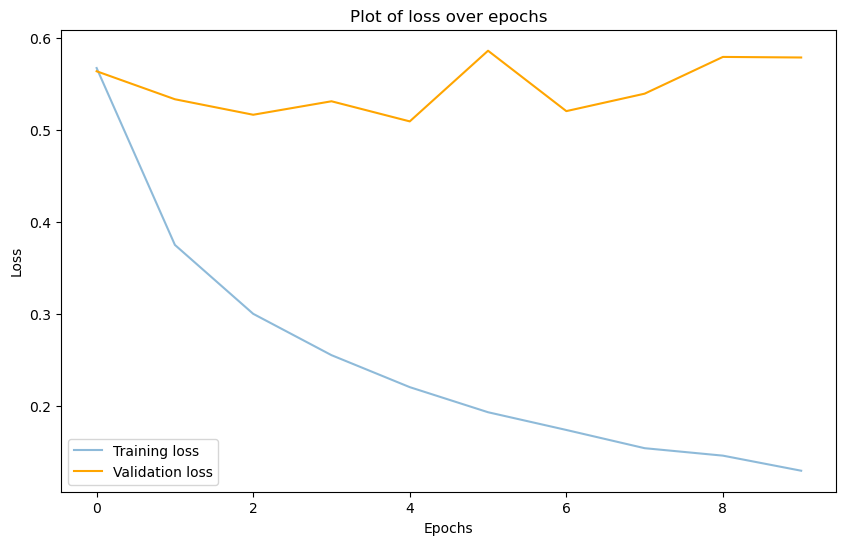

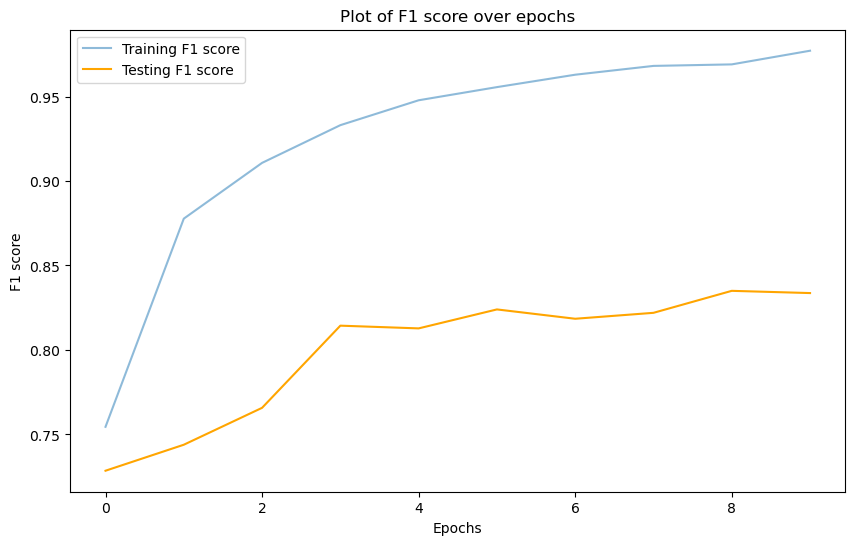

In [89]:
plot_curve(history_base_res_net)

In [58]:
pickle.dump(history_base_res_net, open('./weights/base_res_net_epoch/history_base_res_net.pkl', 'wb'))

| Model                      | Epoch | F1 train | F1 val |
|----------------------------|-------|----------|--------|
| MobileNetV3 + dropout      | 5     | 0.8131   | 0.8086 |
| EfficientNetV2M + dropout  | 9     | 0.8117   | 0.8020 |
| ResNet50                   | 1     | 0.7544   | 0.7285 |
| ResNet50                   | 2     | 0.8777   | 0.7438 |
> It seems like the deeper learning architecture of Resnet50 with its focus on the residual value is resulting the model learning from its error, allowing the train scores to increase higher and quicker but at the cost of significant overfit. This is evident in the large jump in overfit after the first epoch.

### ResNet50 with dropout

In [59]:
# Create base model architecture & instantiate empty sequential model
dropout_res_net = Sequential() 

# Add pre-trained model to use Transfer Learnin (get all the weights from pre_trained_mode)
dropout_res_net.add(res_net) 

#addtional dropout layer
dropout_res_net.add(Dropout(0.5))

# Output layer
dropout_res_net.add(Dense(1, activation= 'sigmoid')) #sigmoid for binary output

# Check model architecture compilation summary
dropout_res_net.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [60]:
#set callbacks

# Instantiating earlystopping
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.02, 
                           patience = 5, 
                           mode = 'auto'
                          )
# Instantiating checkpoint
checkpoint_callback = ModelCheckpoint(filepath = "./weights/dropout_res_net_epoch/dropout_res_net_epoch_{epoch:02d}_{f1_score:.2f}_{val_f1_score:.2f}.h5",
                                      save_weights_only = False,
                                      save_best_only = False,
                                      save_freq = 'epoch',
                                      verbose = 1
                                      )

In [61]:
epochs = 20

# Compile the model with adam optimizer and specify loss type.
opt = Adam(learning_rate=0.001) 
dropout_res_net.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score()])

# Fit train model with early stopping -> higher epochs
history_dropout_res_net = dropout_res_net.fit(x = resnet_train_bin_data,
                                              validation_data = resnet_val_bin_data,
                                              epochs = epochs,
                                              batch_size = 32,
                                              callbacks = [early_stop, checkpoint_callback]
                                              )

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 0.7359 - f1_score: 0.6774
Epoch 1: saving model to ./weights/dropout_res_net_epoch\dropout_res_net_epoch_01_0.68_0.76.h5
98/98 [==============================] - 221s 2s/step - loss: 0.7359 - f1_score: 0.6774 - val_loss: 0.6317 - val_f1_score: 0.7643
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.4970 - f1_score: 0.7900
Epoch 2: saving model to ./weights/dropout_res_net_epoch\dropout_res_net_epoch_02_0.79_0.78.h5
98/98 [==============================] - 219s 2s/step - loss: 0.4970 - f1_score: 0.7900 - val_loss: 0.5783 - val_f1_score: 0.7784
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.4212 - f1_score: 0.8273
Epoch 3: saving model to ./weights/dropout_res_net_epoch\dropout_res_net_epoch_03_0.83_0.79.h5
98/98 [==============================] - 219s 2s/step - loss: 0.4212 - f1_score: 0.8273 - val_loss: 0.5512 - val_f1_score: 0.7913
Epoch 4/20
98/98 [=========================

In [62]:
# pdf the history for quick comparison.
pd.DataFrame(history_dropout_res_net.history, index = pd.RangeIndex(1,len(history_dropout_res_net.history['loss'])+1))

,loss,f1_score,val_loss,val_f1_score
1,0.735911,0.677402,0.631689,0.764293
2,0.497039,0.790049,0.578333,0.778443
3,0.421150,0.827340,0.551177,0.791339
4,0.372455,0.856434,0.530713,0.777778
5,0.348473,0.862411,0.558116,0.803502
6,0.335564,0.873348,0.574481,0.807393
7,0.307940,0.890230,0.540797,0.794688
8,0.297504,0.892808,0.544394,0.823529
9,0.294360,0.891586,0.542915,0.802051


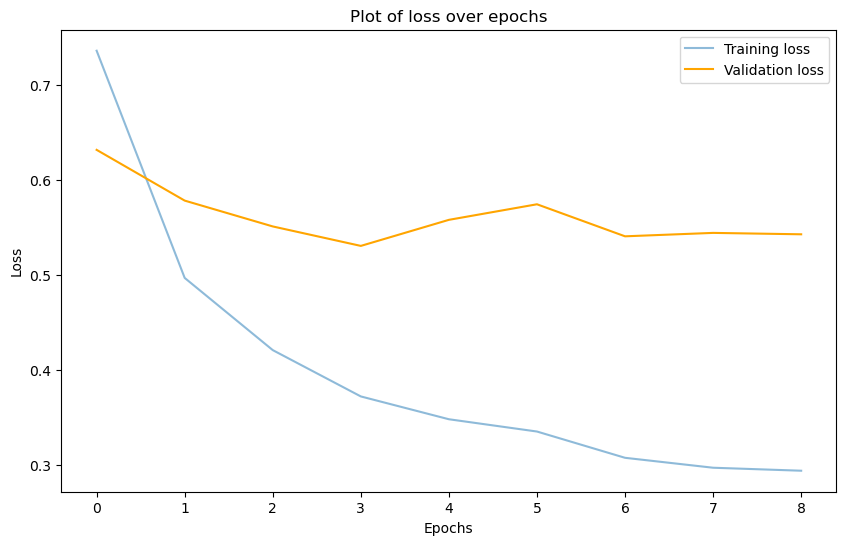

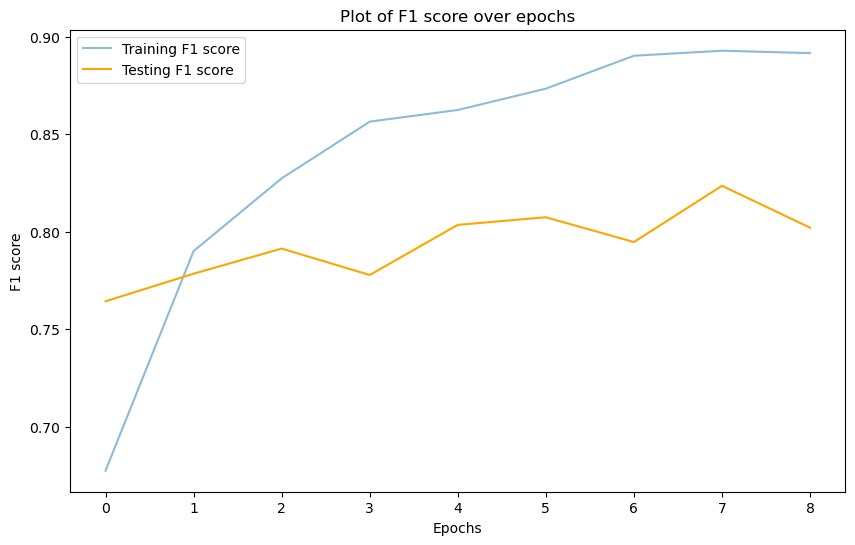

In [91]:
plot_curve(history_dropout_res_net)

In [63]:
pickle.dump(history_dropout_res_net, open('./weights/dropout_res_net_epoch/history_dropout_res_net.pkl', 'wb'))

| Model                      | Epoch | F1 train | F1 val |
|----------------------------|-------|----------|--------|
| MobileNetV3 + dropout      | 5     | 0.8131   | 0.8086 |
| EfficientNetV2M + dropout  | 9     | 0.8117   | 0.8020 |
| ResNet50 + dropout         | 3     | 0.8273   | 0.7913 |

> With the dropout layer, it has bumped up the validation score to 79.1% and has reduced the overfit to about 3.6%. However, it is still not as good on both counts as compared to the MObileNetV3 and EfficientNetV2M model.

## Summary

|  No.  |   Index   | Model                         | epoch |     loss     |  f1_score |  val_loss | val_f1_score | Overfit % |
|:-----:|:---------:|-------------------------------|:-----:|:------------:|:---------:|:---------:|:------------:|:---------:|
| **1** | **3.4.3** | **EfficientNetV2M + dropout** | **9** | **0.458298** | **81.2%** | **50.3%** |   **80.2%**  |  **1.0%** |
|  _2_  |  _3.3.3_  | _MobileNetV3 + dropout_       |  _5_  |  _0.450005_  |  _81.3%_  |  _50.7%_  |    _80.9%_   |   _0.5%_  |
|   3   |   3.4.2   | EfficientNetV2M               |   4   |   0.455341   |   82.5%   |   51.3%   |     79.4%    |    3.1%   |
|   4   |   3.5.3   | ResNet50 + dropout            |   3   |    0.42115   |   82.7%   |   55.1%   |     79.1%    |    3.6%   |
|   5   |   3.2.4   | MobileNetV2 + dropout         |   3   |   0.446019   |   82.4%   |   54.1%   |     81.0%    |    1.4%   |
|   6   |   3.3.2   | MobileNetV3                   |   2   |   0.437409   |   83.3%   |   54.3%   |     77.2%    |    6.1%   |
|   7   |   3.5.2   | ResNet50                      |   1   |   0.567205   |   75.4%   |   56.4%   |     72.8%    |    2.6%   |
|   8   |   3.2.2   | MobileNetV2                   |   1   |   0.543107   |   77.2%   |   55.9%   |     77.2%    |    0.0%   |
|   9   |   3.2.5   | MobillNetV2 + L2 + dropout    |   1   |   1.194217   |   79.6%   |   99.8%   |     79.6%    |    0.0%   |
|   10  |   3.2.3   | MobileNetV2 + l2              |   1   |   1.115498   |   84.6%   |   95.4%   |     82.9%    |    1.8%   |

The above table is sorted by the number of epochs taken to train the model as a lower number of epochs especially at 1, is not preferable.
This is to help give a sense of the models reliability with respect to its performance and overfit (<5% where possible)



Based on the table summary, even though the two models No. 5 (MobileNetV2 + dropout) & No. 10 (MobileNetV2 + l2) has the highest validation F1 score, model no.5 has a higher overfit percentage and is from epoch 3 and model no. 10 is from epoch 1. Therefore, these two model are eliminated from selection. Based on the combination of scores and overfit percentages, the best two models are as follows:

* Model no. 1 (EfficientNetV2M + dropout) in bold, has a F1 Validation score of 80.2% and the lowest overfit at 1%. 
* Model no. 2 (MobileNetV3 + dropout) in italics, has a higher F1 Validation score of 80.9% but a lower overfit and a lower overfit of 0.5%. 

<p float="center">
  <img src="assets/history_dropout_mob_netv3l_F1.png" width="400" />
  <img src="assets/history_dropout_eff_netv2_F1.png" width="400" /> 
</p>

Comparing the loss and f1 curves of models 1 and 2, both are similar in terms of the loss and the F1 score but model 2 has a constantly increasing Train score and has shorter number of epochs before earlystopping kicked in while model has more more progress in improving over more epochs before early stopping kicked in.

Since model 1 utilised EfficientNet architecture while model 2 used Mobilenet architecture, it can be intuited that the EfficientNet architecture having optimising components in the higher number of parameters is working. This hould give it a slightly more generalisable model and hence may give better performance for predicting. 

Since the overarching intention is to have better prediction probabilities, the more generalisable model would be preferred so Model 2 will be used. 

# Conclusion

While a higher score and lower overfit would seem like a logical choice, the fact is that model 1 has gone through 9 epochs of training which is almost double that of model 2. However, looking at the f1 and loss curves, an increasing train score after the best epoch shows a possibly diverging model training. 

This leads to the intuition that for very similar scores and overfit, a model without a constantly increasing (and hence diverging) training curve may be more stable and robust. Especially when considering the model architecture used, in this case EfficientNet, which is known to optimise the network architecture for modelling. Therefore, in the interest of using a more robust model, model no.1 (EfficientNetV2M + dropout) would be used.

Should there be other considerations or requirements, the model 2 can be revisited.
ed.
